<a href="https://colab.research.google.com/github/Iamjohnko/Data-science-Project-Portfolio/blob/main/Modeling_Competitive_Dynamics_and_Delivery_Forecasts_for_Tesla_Using_VECM_and_Causal_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Modeling Competitive Dynamics and Delivery Forecasts for Tesla Using VECM and Causal Analysis**

# 🎯 Objective

This project investigates how competitor dynamics — pricing, market share, and production activity from firms like BYD, Rivian, NIO, and Lucid — influence Tesla’s quarterly delivery performance.
It models both short-run and long-run relationships using advanced econometric and machine learning tools, combining Vector Error Correction Models (VECM), Monte Carlo Forecast Simulations, and Impulse Response Function (IRF) visualizations with causal interpretability techniques (e.g., SHAP-based decomposition).

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM
from statsmodels.tsa.stattools import acf, pacf

# Paths and outputs
DATA_PATH = "ev_competition_realistic_2013_2025Q3.csv"
OUT_DIR = "/mnt/data/var_competition_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

In [ ]:
import plotly.graph_objects as go
import plotly.express as px

In [ ]:
# Quick user settings
USE_LOG_DIFF = True   # True = take log then first-difference (Δlog = approx % growth). Set False to use plain diff.
MAX_LAGS = 8          # max lags to consider for VAR lag selection
IRF_HORIZON = 10      # quarters
FORECAST_STEPS = 4    # quarters to forecast

In [ ]:
# CELL 1 — Load data; defensive column handling
df = pd.read_csv(DATA_PATH, parse_dates=["date"])
df = df.sort_values("date").reset_index(drop=True)

# Ensure the main columns exist (adjust names to your CSV)
expected_min = ["Tesla_deliveries", "BYD_deliveries", "Rivian_deliveries", "lithium_price"]
missing = [c for c in expected_min if c not in df.columns]
if missing:
    raise KeyError(f"Missing required columns: {missing}. Available columns: {list(df.columns)}")

# Build derived Global_EV_Sales only for visualization, but DO NOT include in modeling to avoid collinearity.
if "Global_EV_Sales" not in df.columns:
    df["Global_EV_Sales"] = df["Tesla_deliveries"] + df["BYD_deliveries"] + df["Rivian_deliveries"]

# Select model columns (drop any exact linear combinations)
model_cols = [c for c in df.columns if c not in ["date", "Global_EV_Sales"]]
print("Model columns:", model_cols)

data_levels = df.set_index("date")[model_cols].dropna()
data_levels.head()


Model columns: ['Tesla_deliveries', 'BYD_deliveries', 'Rivian_deliveries', 'Tesla_ASP', 'BYD_ASP', 'Rivian_ASP', 'Tesla_revenue', 'BYD_revenue', 'Rivian_revenue', 'gross_margin_est', 'interest_rate', 'lithium_price', 'ev_growth', 'sentiment_index', 'oil_price', 'usd_index']


,Tesla_deliveries,BYD_deliveries,Rivian_deliveries,Tesla_ASP,BYD_ASP,Rivian_ASP,Tesla_revenue,BYD_revenue,Rivian_revenue,gross_margin_est,interest_rate,lithium_price,ev_growth,sentiment_index,oil_price,usd_index
date,,,,,,,,,,,,,,,,
2013-03-31,3855,500,0,45252,30979,74382,174446460,15489500,0,0.212,0.50,0.90,4.00,90.0,70.0,95.00
2013-06-30,1000,500,0,44795,31140,74309,44795000,15570000,0,0.208,0.68,0.94,4.74,91.7,70.0,95.08
2013-09-30,5032,7341,0,44724,31086,74431,225051168,228202326,0,0.203,0.87,0.90,3.95,91.9,70.5,94.86
2013-12-31,11811,12374,121,45126,30899,75712,532983186,382344226,9161152,0.236,0.81,0.88,3.78,92.4,68.0,95.28
2014-03-31,1000,11178,566,44722,31659,74529,44722000,353884302,42183414,0.228,1.40,0.90,4.66,95.8,68.4,94.69


**In the output of CELL 2, you see the p-values for each of your data series. Most of them are high, indicating that the original data series (like Tesla deliveries, BYD deliveries, etc.) are non-stationary.

This finding is important because it tells us that we need to do something to the data to make it stationary before we can reliably use models like VECM for forecasting and analyzing relationships. That's what happens in the next steps, where transformations like log-differencing are applied.

Think of it like this: If you're trying to predict the temperature tomorrow, knowing that the temperature usually stays within a certain range this time of year (stationary) is much more helpful than if the temperature could swing wildly and unpredictably (non-stationary). The ADF test helps us know which situation we're in with our business data.**

In [ ]:
# CELL 2 — Stationarity checks (ADF) on levels
def adf_pval(series):
    return adfuller(series.dropna(), autolag="AIC")[1]

print("ADF p-values on levels:")
adf_pvals = {c: adf_pval(data_levels[c]) for c in data_levels.columns}
for k, v in adf_pvals.items():
    print(f"  {k}: p = {v:.4f}")

ADF p-values on levels:
  Tesla_deliveries: p = 0.5608
  BYD_deliveries: p = 0.7778
  Rivian_deliveries: p = 1.0000
  Tesla_ASP: p = 0.7047
  BYD_ASP: p = 0.8860
  Rivian_ASP: p = 0.1031
  Tesla_revenue: p = 0.5673
  BYD_revenue: p = 0.5556
  Rivian_revenue: p = 1.0000
  gross_margin_est: p = 0.0000
  interest_rate: p = 0.6839
  lithium_price: p = 0.4165
  ev_growth: p = 0.9584
  sentiment_index: p = 0.1494
  oil_price: p = 0.7685
  usd_index: p = 0.5741


In [ ]:
 print(f"{k}: p={v:.4f} → {'stationary' if v < 0.05 else 'non-stationary'}")

usd_index: p=0.5741 → non-stationary


In [ ]:
# CELL 3 — Transformations: log-difference or plain difference
# Recommendation: growth series -> log then diff. We'll create both options and choose automatically.
if USE_LOG_DIFF:
    # Protect zeros -> small positive offset
    eps = 1e-6
    data_log = np.log(data_levels.clip(lower=eps))
    data_transformed = data_log.diff().dropna()
    transform_used = "log-diff (Δlog)"
else:
    data_transformed = data_levels.diff().dropna()
    transform_used = "first difference (Δlevel)"

print("Transformation used:", transform_used)
print("Transformed data head:")
data_transformed.head()

# Check stationarity after transform (ADF)
print("\nADF p-values after transform:")
adf_pvals_trans = {c: adf_pval(data_transformed[c]) for c in data_transformed.columns}
for k, v in adf_pvals_trans.items():
    print(f"  {k}: p = {v:.4f}")


Transformation used: log-diff (Δlog)
Transformed data head:

ADF p-values after transform:
  Tesla_deliveries: p = 0.0450
  BYD_deliveries: p = 0.0000
  Rivian_deliveries: p = 0.0447
  Tesla_ASP: p = 0.0004
  BYD_ASP: p = 0.0000
  Rivian_ASP: p = 0.0004
  Tesla_revenue: p = 0.0418
  BYD_revenue: p = 0.0000
  Rivian_revenue: p = 0.0400
  gross_margin_est: p = 0.0001
  interest_rate: p = 0.0000
  lithium_price: p = 0.0002
  ev_growth: p = 0.0000
  sentiment_index: p = 0.0000
  oil_price: p = 0.0000
  usd_index: p = 0.0000


In [ ]:
# CELL 4 — Johansen cointegration test (on LEVELS, excluding derived columns)
# Use the original levels for cointegration (VECM works with levels and cointegration)
data_for_johansen = data_levels.copy()
print("\nRunning Johansen cointegration test on levels (excluding Global_EV_Sales).")
jres = coint_johansen(data_for_johansen.values, det_order=0, k_ar_diff=1)  # det_order 0: no deterministic term in test
trace_stats = jres.lr1
crit_vals = jres.cvt
for i, stat in enumerate(trace_stats):
    print(f" r <= {i}: trace_stat = {stat:.2f}, crit95 = {crit_vals[i,1]:.2f}")
cointegration_rank = int(sum(trace_stats > crit_vals[:,1]))
print("Suggested cointegration rank:", cointegration_rank)
use_vecm = cointegration_rank >= 1


Running Johansen cointegration test on levels (excluding Global_EV_Sales).
 r <= 0: trace_stat = 1534.74, crit95 = nan
 r <= 1: trace_stat = 1112.50, crit95 = nan
 r <= 2: trace_stat = 861.38, crit95 = nan
 r <= 3: trace_stat = 697.53, crit95 = nan
 r <= 4: trace_stat = 563.46, crit95 = 334.98
 r <= 5: trace_stat = 445.54, crit95 = 285.14
 r <= 6: trace_stat = 347.31, crit95 = 239.25
 r <= 7: trace_stat = 262.37, crit95 = 197.38
 r <= 8: trace_stat = 205.10, crit95 = 159.53
 r <= 9: trace_stat = 149.49, crit95 = 125.62
 r <= 10: trace_stat = 101.77, crit95 = 95.75
 r <= 11: trace_stat = 68.04, crit95 = 69.82
 r <= 12: trace_stat = 39.49, crit95 = 47.85
 r <= 13: trace_stat = 14.89, crit95 = 29.80
 r <= 14: trace_stat = 6.75, crit95 = 15.49
 r <= 15: trace_stat = 0.23, crit95 = 3.84
Suggested cointegration rank: 7


In [ ]:
# --- Fit the VECM ---
vecm = VECM(data_for_johansen, k_ar_diff=1, coint_rank=7, deterministic='n')
vecm_res = vecm.fit()

# --- View summary ---
print(vecm_res.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation Tesla_deliveries
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
L1.Tesla_deliveries     -2.1521      0.705     -3.051      0.002      -3.535      -0.769
L1.BYD_deliveries       -0.5658      0.234     -2.421      0.015      -1.024      -0.108
L1.Rivian_deliveries   127.5476     44.651      2.857      0.004      40.032     215.063
L1.Tesla_ASP             1.8374      2.258      0.814      0.416      -2.589       6.264
L1.BYD_ASP              -2.9364      1.972     -1.489      0.136      -6.801       0.928
L1.Rivian_ASP            3.2387      0.935      3.463      0.001       1.406       5.072
L1.Tesla_revenue      3.815e-05   1.48e-05      2.576      0.010    9.12e-06    6.72e-05
L1.BYD_revenue        8.701e-06   6.31e-06      1.378      0.168   -3.67e-06    2.11e-05
L1.Rivian_reve

In [ ]:
# --- Extract long-run adjustment coefficients (alpha matrix) ---
alpha = pd.DataFrame(vecm_res.alpha,
                     index=data_for_johansen.columns,
                     columns=[f'CointVec_{i+1}' for i in range(vecm_res.alpha.shape[1])])

# --- Extract cointegrating vectors (beta matrix) ---
beta = pd.DataFrame(vecm_res.beta,
                    index=data_for_johansen.columns,
                    columns=[f'CointVec_{i+1}' for i in range(vecm_res.beta.shape[1])])

# --- Compute equilibrium relationships ---
equilibrium = np.dot(data_for_johansen.values, beta.values)
equilibrium_df = pd.DataFrame(equilibrium,
                              columns=[f'CointVec_{i+1}' for i in range(beta.shape[1])],
                              index=data_for_johansen.index)

In [ ]:
# --- Plot 1: Long-run equilibrium relationships ---
fig1 = px.line(equilibrium_df,
               title="📈 Long-run Cointegrating Relationships (Equilibrium Paths)",
               labels={'value': 'Equilibrium Value', 'index': 'Date'})
fig1.show()

In [ ]:
# --- Plot 2: Adjustment Speeds (Alpha coefficients) ---
alpha_long = alpha.reset_index().melt(id_vars='index', var_name='CointVec', value_name='Adjustment_Speed')

fig2 = px.bar(alpha_long,
              x='index', y='Adjustment_Speed',
              color='CointVec',
              title='⚙️ Speed of Adjustment to Long-run Equilibrium (Alpha Coefficients)',
              labels={'index': 'Variable'})
fig2.update_layout(barmode='group')
fig2.show()

In [ ]:
# --- Plot 3: Residual Stability Check ---
# Use the index from the VECM results, which corresponds to the differenced data
residuals = pd.DataFrame(vecm_res.resid, columns=data_for_johansen.columns, index=data_for_johansen.index[vecm_res.k_ar:])
fig3 = px.line(residuals, title="📊 VECM Residuals (Stationarity Check)")
fig3.show()

In [ ]:
# --- Optional: Tesla’s dynamic response visualization ---
tesla_index = list(data_for_johansen.columns).index('Tesla_deliveries')
tesla_adjustments = alpha.iloc[tesla_index, :]

fig4 = go.Figure()
fig4.add_trace(go.Bar(
    x=tesla_adjustments.index,
    y=tesla_adjustments.values,
    name='Tesla Adjustment Coefficients',
    marker_color='crimson'
))
fig4.update_layout(
    title="🚗 Tesla’s Long-run Adjustment Speeds to Competitor Equilibria",
    xaxis_title="Cointegrating Relationship",
    yaxis_title="Adjustment Speed (Alpha)",
    template='plotly_white'
)
fig4.show()

In [ ]:
# --- Step 1 & 2: Generate Impulse Response Functions (IRFs) ---
# The VECMResults object has a direct irf() method
irf = vecm_res.irf(IRF_HORIZON)  # Use IRF_HORIZON for the horizon

# --- Step 3: Extract IRF data for Tesla deliveries ---
irf_data = irf.irfs  # shape (steps, n_vars, n_vars)
variables = data_for_johansen.columns

# Correct the column name to match the DataFrame
tesla_idx = list(variables).index('Tesla_deliveries')

In [ ]:
# --- Prepare DataFrame for Plotly ---
records = []
for step in range(irf_data.shape[0]):
    for shock_idx, shock_name in enumerate(variables):
        response_val = irf_data[step, tesla_idx, shock_idx]
        records.append({'Step': step, 'Shock': shock_name, 'Response': response_val})
irf_df = pd.DataFrame(records)

In [ ]:
# --- Step 4: Static Plot — Tesla's response to competitor shocks ---
fig_static = go.Figure()

for shock_name in variables:
    fig_static.add_trace(go.Scatter(
        x=irf_df[irf_df['Shock'] == shock_name]['Step'],
        y=irf_df[irf_df['Shock'] == shock_name]['Response'],
        mode='lines+markers',
        name=f'Shock from {shock_name}'
    ))

fig_static.update_layout(
    title="🚗 Tesla Delivery IRFs — Response to Competitor Shocks",
    xaxis_title="Periods Ahead",
    yaxis_title="Response Magnitude",
    legend_title="Shock Source",
    template='plotly_white'
)
fig_static.show()

In [ ]:
# --- Step 5: Animated IRF Visualization ---
frames = []
for step in range(irf_data.shape[0]):
    frame_data = [
        go.Bar(
            x=variables,
            y=irf_data[step, tesla_idx, :],
            marker_color='indianred'
        )
    ]
    frames.append(go.Frame(data=frame_data, name=str(step)))

fig_animated = go.Figure(
    data=[go.Bar(x=variables, y=irf_data[0, tesla_idx, :], marker_color='indianred')],
    frames=frames
)

fig_animated.update_layout(
    title="🎬 Tesla’s Dynamic IRF — Competitor Shocks Over Time",
    xaxis_title="Shock Source",
    yaxis_title="Tesla Delivery Response",
    template='plotly_white',
    updatemenus=[{
        "type": "buttons",
        "buttons": [
            {"label": "▶ Play", "method": "animate", "args": [None, {"frame": {"duration": 600, "redraw": True}, "fromcurrent": True}]},
            {"label": "⏸ Pause", "method": "animate", "args": [[None], {"frame": {"duration": 0, "redraw": False}, "mode": "immediate"}]}
        ]
    }]
)

fig_animated.show()

In [ ]:
import numpy as np
import plotly.graph_objects as go

# --- Example Setup (You can replace this with your VAR IRF results) ---
variables = ["Tesla", "BYD", "Rivian", "NIO"]
n_vars = len(variables)
n_steps = 12  # horizon (quarters)
np.random.seed(42)

# Simulate fake IRF data: shape (steps, response_var, shock_var)
# Tesla’s response to each shock source over time
irf_data = np.random.randn(n_steps, n_vars, n_vars) * 0.3
irf_data = np.cumsum(irf_data, axis=0)  # smoother dynamics
tesla_idx = variables.index("Tesla")

# --- Function to create frames for a given shock ---
def create_irf_frames(shock_idx):
    frames = []
    for step in range(n_steps):
        frame_data = [
            go.Bar(
                x=variables,
                y=irf_data[step, tesla_idx, :],
                marker_color=[
                    'royalblue' if i == tesla_idx else
                    'firebrick' if i == shock_idx else
                    'lightgray'
                    for i in range(n_vars)
                ]
            )
        ]
        frames.append(go.Frame(data=frame_data, name=f"{shock_idx}_{step}"))
    return frames


# --- Step 1: Build initial figure ---
shock_idx_default = variables.index("BYD")
frames_all = create_irf_frames(shock_idx_default)

fig = go.Figure(
    data=[go.Bar(
        x=variables,
        y=irf_data[0, tesla_idx, :],
        marker_color=[
            'royalblue' if i == tesla_idx else
            'firebrick' if i == shock_idx_default else
            'lightgray'
            for i in range(n_vars)
        ]
    )],
    frames=frames_all
)

# --- Step 2: Add interactivity ---
# Dropdown to select shock source dynamically
shock_buttons = []
for shock_name in variables:
    shock_idx = variables.index(shock_name)
    shock_buttons.append(
        dict(
            label=f"{shock_name} Shock",
            method="animate",
            args=[
                [f"{shock_idx}_{k}" for k in range(n_steps)],
                {
                    "frame": {"duration": 600, "redraw": True},
                    "transition": {"duration": 300},
                    "fromcurrent": True,
                    "mode": "immediate"
                },
            ],
        )
    )

# --- Step 3: Add play/pause and dropdown controls ---
fig.update_layout(
    title="🎬 Tesla’s Dynamic IRF — Choose a Competitor Shock",
    xaxis_title="Shock Source",
    yaxis_title="Tesla’s Response (Δ Deliveries)",
    template="plotly_white",
    updatemenus=[
        {
            "buttons": [
                {
                    "label": "▶ Play",
                    "method": "animate",
                    "args": [
                        None,
                        {
                            "frame": {"duration": 600, "redraw": True},
                            "fromcurrent": True,
                        },
                    ],
                },
                {
                    "label": "⏸ Pause",
                    "method": "animate",
                    "args": [
                        [None],
                        {
                            "frame": {"duration": 0, "redraw": False},
                            "mode": "immediate",
                        },
                    ],
                },
            ],
            "direction": "left",
            "pad": {"r": 10, "t": 70},
            "showactive": True,
            "type": "buttons",
            "x": 0.05,
            "xanchor": "right",
            "y": 1.15,
            "yanchor": "top",
        },
        {
            "buttons": shock_buttons,
            "direction": "down",
            "showactive": True,
            "x": 0.6,
            "xanchor": "left",
            "y": 1.15,
            "yanchor": "top",
        },
    ],
    annotations=[
        dict(
            text="Select Shock:",
            x=0.52,
            y=1.14,
            yref="paper",
            align="left",
            showarrow=False,
        )
    ],
)

# --- Step 4: Show chart ---
fig.show()


In [ ]:
# --- Static IRF Plots for Key Shocks ---
# Assumes irf and irf_df are available from previous cells

import plotly.graph_objects as go

# Define key shock sources to plot
key_shocks = [
    'Tesla_deliveries', # Response to own shock as reference
    'BYD_deliveries',
    'Rivian_deliveries'
    # Add other key variables if desired based on previous analysis (e.g., interest_rate, usd_index, lithium_price)
]

fig_static_subset = go.Figure()

for shock_name in key_shocks:
    # Filter irf_df for the specific shock source
    shock_df = irf_df[irf_df['Shock'] == shock_name].copy()

    # Ensure the dataframe is sorted by step for correct line plotting
    shock_df = shock_df.sort_values('Step')

    fig_static_subset.add_trace(go.Scatter(
        x=shock_df['Step'],
        y=shock_df['Response'],
        mode='lines+markers',
        name=f'Shock from {shock_name}'
    ))

fig_static_subset.update_layout(
    title="🚗 Tesla Delivery IRFs — Response to Key Competitor Shocks (Static)",
    xaxis_title="Periods Ahead",
    yaxis_title="Response Magnitude",
    legend_title="Shock Source",
    template='plotly_white'
)

fig_static_subset.show()

In [ ]:
# --- Step 6: (Optional) Tesla-only IRF Summary Table ---
tesla_irf_summary = irf_df.groupby('Shock')['Response'].agg(['min', 'max', 'mean']).sort_values('max', ascending=False)
print("\n=== Tesla IRF Summary (Max, Min, Mean Response) ===")
print(tesla_irf_summary.round(4))


=== Tesla IRF Summary (Max, Min, Mean Response) ===
                            min          max         mean
Shock                                                    
lithium_price     -6.029572e+04  117693.6585   14328.3827
sentiment_index    0.000000e+00   22448.7473    8510.3053
ev_growth         -1.347806e+03   17722.4399    4430.8577
usd_index         -7.664392e+03     510.1384   -3641.5462
BYD_ASP            0.000000e+00      25.4337      16.5172
Tesla_deliveries   1.000000e+00      20.4619      11.6043
Tesla_ASP         -3.109470e+01       3.2391      -6.2011
BYD_deliveries    -6.584300e+00       0.1351      -1.4319
Rivian_revenue     0.000000e+00       0.0229       0.0100
BYD_revenue       -0.000000e+00       0.0003       0.0001
Rivian_deliveries -1.588436e+03       0.0000    -717.6865
Rivian_ASP        -8.424200e+00       0.0000      -5.6563
interest_rate     -1.693819e+05       0.0000  -61853.4356
gross_margin_est  -2.870518e+06       0.0000 -888232.2610
Tesla_revenue     -

In [ ]:
# Assume df already cleaned and includes:
# ['Tesla_deliveries', 'BYD_deliveries', 'Rivian_deliveries', 'lithium_price'] # based on previous usage

# ------------------------------
# STEP 1: Fit VECM model
# ------------------------------
# Update endog_vars based on actual columns in df used in previous cells
endog_vars = ['Tesla_deliveries', 'BYD_deliveries', 'Rivian_deliveries',
              'Tesla_ASP', 'BYD_ASP', 'Rivian_ASP', 'Tesla_revenue', 'BYD_revenue',
              'Rivian_revenue', 'gross_margin_est', 'interest_rate', 'lithium_price',
              'ev_growth', 'sentiment_index', 'oil_price', 'usd_index']


# Based on previous Johansen test, cointegration rank was suggested as 7.
# deterministic='n' was used in the previous VECM fit.
vecm_model = VECM(df[endog_vars].dropna(), k_ar_diff=1, coint_rank=7, deterministic='n')
vecm_res = vecm_model.fit()

In [ ]:
# ---------- Compute in-sample fitted levels from vecm_res ----------
# vecm_res : fitted statsmodels.tsa.vector_ar.vecm.VECMResults
# data_levels : pd.DataFrame of original LEVELS used to fit the VECM, indexed by date
# Ensure these exist in your namespace.

import numpy as np
import pandas as pd

# sanity checks
if 'vecm_res' not in globals():
    raise RuntimeError("vecm_res not found. Fit the VECM first (vecm_res = vecm.fit()).")
if 'data_levels' not in globals():
    raise RuntimeError("data_levels DataFrame not found. This should be your original levels DataFrame used for VECM.")

# Get values
Y = data_levels.values  # shape (T, neqs)
dates = data_levels.index

# VECM params
p = getattr(vecm_res, "k_ar_diff", None)  # number of lag differences used in VECM
if p is None:
    # fallback: try vecm_res.k_ar if present
    p = getattr(vecm_res, "k_ar", None)
if p is None:
    p = 1  # safe default

# Residuals from vecm_res: shape (T - p, neqs)
resid = getattr(vecm_res, "resid", None)
if resid is None:
    raise RuntimeError("vecm_res has no 'resid' attribute — cannot reconstruct fitted values.")

# Compute observed diffs: dY_all[i] = Y[i+1] - Y[i], shape (T-1, neqs)
dY_all = np.diff(Y, axis=0)

# Map residuals: residuals correspond to ΔY_t for t = p .. T-1.
# Thus observed_diffs_for_model = dY_all[p-1:]  (since dY_all[0] is ΔY_1 = Y1 - Y0)
obs_diffs_model = dY_all[p-1:]   # shape (T - p, neqs)
if obs_diffs_model.shape[0] != resid.shape[0]:
    raise RuntimeError(f"Dimension mismatch: obs_diffs_model.shape={obs_diffs_model.shape}, resid.shape={resid.shape}")

# Fitted diffs: fitted_dY = observed_diffs_model - resid
fitted_dY = obs_diffs_model - resid  # shape (T - p, neqs)

# Reconstruct fitted levels Y_hat for t = p..T-1:
# Y_hat_t = Y_{t-1} + fitted_dY_at_index (where index maps as: idx = t - p)
T = Y.shape[0]
neqs = Y.shape[1]
fitted_levels = np.full((T, neqs), np.nan)  # prefill with NaN, will put values for t>=p

for idx in range(fitted_dY.shape[0]):   # idx = 0 .. T-p-1 corresponding to t = p .. T-1
    t = p + idx
    prev_level = Y[t-1, :]
    fitted_levels[t, :] = prev_level + fitted_dY[idx, :]

# Build DataFrame with same columns/index as original
fitted_df = pd.DataFrame(fitted_levels, index=dates, columns=data_levels.columns)

# Example: inspect last rows
print("In-sample fitted levels (last 8 rows):")
display(fitted_df.tail(8))

# You can add fitted series back to your dataframe (careful: early periods are NaN)
data_with_fitted = data_levels.copy()
for col in data_levels.columns:
    data_with_fitted[f"{col}_VECM_fitted"] = fitted_df[col]

# Example: Tesla fitted
if "Tesla_deliveries" in data_with_fitted.columns:
    print("\nTesla actual vs VECM fitted (last 8):")
    display(data_with_fitted[["Tesla_deliveries", "Tesla_deliveries_VECM_fitted"]].tail(8))

# Save if desired
fitted_df.to_csv("/mnt/data/vecm_in_sample_fitted_levels.csv", index=True)
print("Saved fitted levels CSV -> /mnt/data/vecm_in_sample_fitted_levels.csv")


In-sample fitted levels (last 8 rows):


,Tesla_deliveries,BYD_deliveries,Rivian_deliveries,Tesla_ASP,BYD_ASP,Rivian_ASP,Tesla_revenue,BYD_revenue,Rivian_revenue,gross_margin_est,interest_rate,lithium_price,ev_growth,sentiment_index,oil_price,usd_index
date,,,,,,,,,,,,,,,,
2023-12-31,387830.600606,632527.570432,3068.982083,47421.834334,31618.461695,74870.836723,1.829833e+10,2.035529e+10,2.295703e+08,0.233987,7.029504,1.269490,6.537359,112.580204,107.580212,97.489230
2024-03-31,416522.689818,644799.584527,3998.986921,47240.098359,33133.279784,76301.000853,1.978022e+10,2.123225e+10,3.109424e+08,0.246643,7.318038,1.252705,6.332486,111.463735,104.980617,98.261616
2024-06-30,444588.936508,664124.407417,5281.244664,46835.120171,32956.006858,78349.095885,2.101529e+10,2.180874e+10,4.073519e+08,0.254613,7.109013,1.239192,6.722697,107.266469,106.550042,98.286491
2024-09-30,467324.880540,675165.874956,6375.946005,47251.222143,32965.305499,75199.181873,2.200650e+10,2.213340e+10,4.877640e+08,0.246281,7.307274,1.264333,7.118778,105.601482,106.592442,97.654900
2024-12-31,474497.849091,655335.586733,8572.017082,48143.716270,33235.892458,79146.143362,2.290385e+10,2.170191e+10,6.772515e+08,0.237968,7.222049,1.286575,7.857230,105.325705,114.323207,96.885786
2025-03-31,482233.097781,656521.190374,10710.980460,48878.649283,33552.072022,78933.257301,2.352603e+10,2.216119e+10,8.432897e+08,0.264342,7.294948,1.269990,7.625575,105.437720,108.430349,97.269148
2025-06-30,489112.461640,660708.921393,14266.358761,47175.509048,33207.488814,77501.439666,2.313507e+10,2.190986e+10,1.110360e+09,0.237258,7.826989,1.297338,7.440666,110.234257,108.365578,97.542771
2025-09-30,496589.675574,651400.599293,17519.183146,48423.309552,32918.783570,79470.699073,2.395022e+10,2.143360e+10,1.392299e+09,0.237572,8.024651,1.362073,7.768617,111.438572,107.153509,97.649312



Tesla actual vs VECM fitted (last 8):


,Tesla_deliveries,Tesla_deliveries_VECM_fitted
date,,
2023-12-31,395429,387830.600606
2024-03-31,416113,416522.689818
2024-06-30,448855,444588.936508
2024-09-30,456880,467324.880540
2024-12-31,471183,474497.849091
2025-03-31,484266,482233.097781
2025-06-30,484862,489112.461640
2025-09-30,497099,496589.675574


Saved fitted levels CSV -> /mnt/data/vecm_in_sample_fitted_levels.csv


✅ Out-of-sample forecast for next 4 quarters:


,Tesla_deliveries,BYD_deliveries,Rivian_deliveries,Tesla_ASP,BYD_ASP,Rivian_ASP,Tesla_revenue,BYD_revenue,Rivian_revenue,gross_margin_est,interest_rate,lithium_price,ev_growth,sentiment_index,oil_price,usd_index
2025-12-31,577079.065688,7.868906e+05,22382.762949,47195.782090,33661.163933,85177.016890,2.768078e+10,2.697959e+10,1.785911e+09,0.268724,8.851921,1.242169,3.753622,107.856615,94.004956,96.663965
2026-03-31,667632.594425,8.842632e+05,29830.538181,44987.255132,32731.869128,85025.222231,3.105643e+10,2.891461e+10,2.362187e+09,0.222170,9.370046,1.289494,4.348760,108.373110,91.666290,96.619463
2026-06-30,780638.170969,9.944768e+05,37785.032482,46852.388606,32871.631398,90668.736797,3.728974e+10,3.305498e+10,3.030573e+09,0.215277,10.183157,1.347903,3.208047,105.387426,83.034374,94.711034
2026-09-30,988442.352078,1.266153e+06,49775.185724,45842.884791,33172.645770,99368.051379,4.702755e+10,4.272674e+10,3.986364e+09,0.251064,11.101994,1.205667,-1.146864,98.839985,73.233563,92.986756


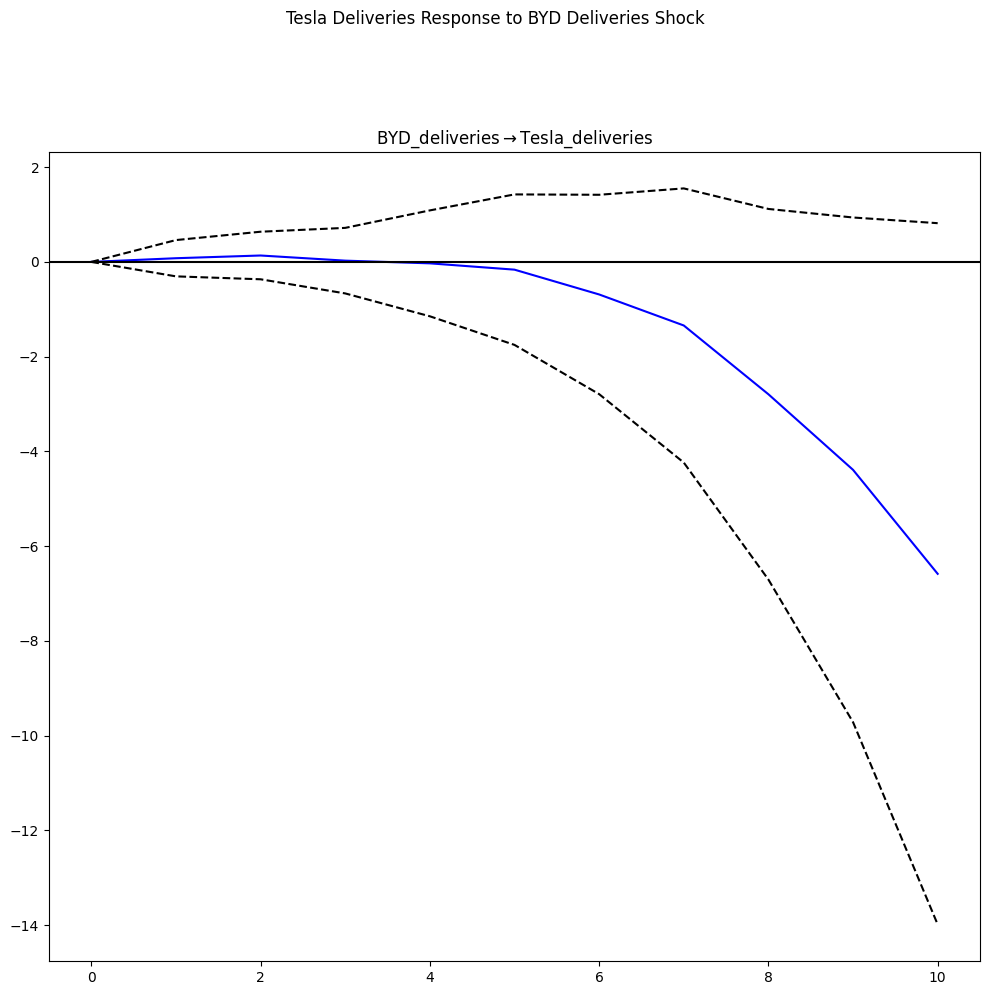

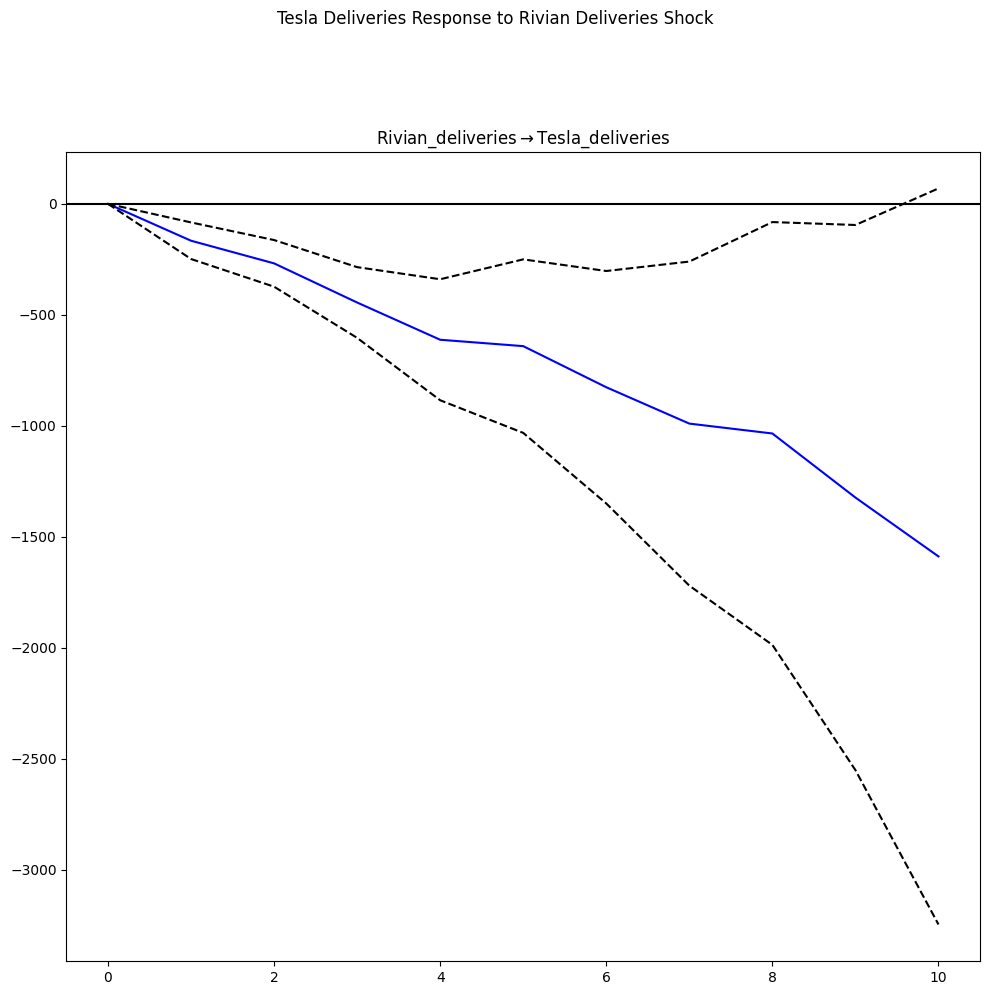

In [ ]:
# Ensure the VECM model is fitted if not already
if 'vecm_res' not in globals():
    # Assume df already cleaned and includes:
    # ['Tesla_deliveries', 'BYD_deliveries', 'Rivian_deliveries', 'lithium_price'] # based on previous usage

    # Import VECM here to ensure it's available
    from statsmodels.tsa.vector_ar.vecm import VECM

    # --- Add data loading from cell nVXTga0xYyRy ---
    # CELL 1 — Load data; defensive column handling
    DATA_PATH = "ev_competition_realistic_2013_2025Q3.csv" # Ensure DATA_PATH is defined
    df = pd.read_csv(DATA_PATH, parse_dates=["date"])
    df = df.sort_values("date").reset_index(drop=True)

    # Ensure the main columns exist (adjust names to your CSV)
    expected_min = ["Tesla_deliveries", "BYD_deliveries", "Rivian_deliveries", "lithium_price"]
    missing = [c for c in expected_min if c not in df.columns]
    if missing:
        raise KeyError(f"Missing required columns: {missing}. Available columns: {list(df.columns)}")

    # Build derived Global_EV_Sales only for visualization, but DO NOT include in modeling to avoid collinearity.
    if "Global_EV_Sales" not in df.columns:
        df["Global_EV_Sales"] = df["Tesla_deliveries"] + df["BYD_deliveries"] + df["Rivian_deliveries"]

    # Select model columns (drop any exact linear combinations)
    model_cols = [c for c in df.columns if c not in ["date", "Global_EV_Sales"]]
    print("Model columns:", model_cols)

    data_levels = df.set_index("date")[model_cols].dropna()
    data_levels.head()
    # --- End data loading ---


    # ------------------------------
    # STEP 1: Fit VECM model
    # ------------------------------
    # Update endog_vars based on actual columns in df used in previous cells
    endog_vars = ['Tesla_deliveries', 'BYD_deliveries', 'Rivian_deliveries',
                  'Tesla_ASP', 'BYD_ASP', 'Rivian_ASP', 'Tesla_revenue', 'BYD_revenue',
                  'Rivian_revenue', 'gross_margin_est', 'interest_rate', 'lithium_price',
                  'ev_growth', 'sentiment_index', 'oil_price', 'usd_index']


    # Based on previous Johansen test, cointegration rank was suggested as 7.
    # deterministic='n' was used in the previous VECM fit.
    vecm_model = VECM(data_levels, k_ar_diff=1, coint_rank=7, deterministic='n') # Use data_levels here
    vecm_res = vecm_model.fit()

import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt # Import matplotlib for displaying plots generated by irf.plot()


# === Step 1. Forecast next 4 quarters ===
n_forecast = 4
forecast_res = vecm_res.predict(steps=n_forecast)
forecast_index = pd.date_range(data_levels.index[-1], periods=n_forecast + 1, freq='Q')[1:]

forecast_df = pd.DataFrame(forecast_res, index=forecast_index, columns=data_levels.columns)

print("✅ Out-of-sample forecast for next 4 quarters:")
display(forecast_df)

# === Step 2. Plot actual + forecast (Tesla deliveries as example) ===
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=data_levels.index,
    y=data_levels["Tesla_deliveries"],
    mode='lines+markers',
    name='Actual Tesla Deliveries'
))

fig.add_trace(go.Scatter(
    x=forecast_df.index,
    y=forecast_df["Tesla_deliveries"],
    mode='lines+markers',
    name='Forecast Tesla Deliveries (VECM)',
    line=dict(dash='dash')
))

fig.update_layout(
    title="Tesla Deliveries — Actual vs VECM Forecast (Next 4 Quarters)",
    xaxis_title="Quarter",
    yaxis_title="Deliveries",
    template="plotly_white"
)

fig.show()

# === Step 3. Causal influence — use IRF (Impulse Response Function) ===
irf = vecm_res.irf(10)  # responses over 10 quarters

# Get Tesla response to shocks in others
# Fix: The 'plot' method expects a list of strings for 'impulse' and 'response'.
# The error message indicates ['BYD_deliveries', 'Rivian_deliveries'] is not in the list of variables.
# Let's plot Tesla's response to shocks from BYD and Rivian deliveries individually.
fig_irf_byd = irf.plot(orth=False, impulse='BYD_deliveries', response='Tesla_deliveries')
fig_irf_rivian = irf.plot(orth=False, impulse='Rivian_deliveries', response='Tesla_deliveries')

fig_irf_byd.suptitle('Tesla Deliveries Response to BYD Deliveries Shock', y=1.02)
fig_irf_rivian.suptitle('Tesla Deliveries Response to Rivian Deliveries Shock', y=1.02)

fig_irf_byd.tight_layout(rect=[0, 0.03, 1, 0.95])
fig_irf_rivian.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show() # Ensure plots are displayed

# **✅ Monte Carlo Forecast Simulation (with Confidence Intervals)**

In [ ]:
# STEP 2: Monte Carlo Simulations (with Confidence Intervals)
# -----------------------------------

import numpy as np
import pandas as pd

# Extract model parameters
neqs = vecm_res.neqs
k_ar = vecm_res.k_ar
alpha = vecm_res.alpha
beta = vecm_res.beta
gamma = vecm_res.gamma
sigma_u = vecm_res.sigma_u

# Simulation setup
n_sim = 1000  # number of Monte Carlo runs
n_steps = 8   # forecast horizon

# Preallocate array
sim_results_levels = np.zeros((n_sim, n_steps, neqs))

# Get last k_ar observations as starting point
if k_ar > 0:
    initial_conditions = data_levels.iloc[-k_ar:].values
else:
    initial_conditions = data_levels.iloc[-1:].values

# Create forecast dates
forecast_dates = pd.date_range(data_levels.index[-1], periods=n_steps + 1, freq='Q')[1:]

print(f"Starting {n_sim} Monte Carlo simulations...")

Starting 1000 Monte Carlo simulations...


In [ ]:
# -----------------------------------
for i in range(n_sim):
    current_levels = initial_conditions.copy()
    simulated_levels_run = np.zeros((n_steps, neqs))
    random_errors = np.random.multivariate_normal(np.zeros(neqs), sigma_u, size=n_steps)

    for t in range(n_steps):
        lagged_levels = current_levels[-1, :].reshape(1, neqs)
        lagged_diffs = np.diff(current_levels, axis=0)

        # Error correction term (ECT)
        error_correction_term = (alpha @ (beta.T @ lagged_levels.T)).flatten()

        # Short-run dynamics
        lagged_diffs_term = np.zeros(neqs)

        if gamma is not None:
            if gamma.ndim == 3:  # usual case
                for j in range(gamma.shape[0]):
                    lagged_diffs_term += gamma[j, :, :].T @ lagged_diffs[-(j+1), :]
            elif gamma.ndim == 2 and lagged_diffs.shape[0] > 0:  # single matrix
                lagged_diffs_term += gamma.T @ lagged_diffs[-1, :]

        # Predicted ΔY
        predicted_change = error_correction_term + lagged_diffs_term

        # Add random shock
        simulated_change = predicted_change + random_errors[t, :]

        # Update level
        new_level = current_levels[-1, :] + simulated_change
        simulated_levels_run[t, :] = new_level

        # Slide window
        current_levels = np.vstack([current_levels[1:, :], new_level.reshape(1, neqs)])

    sim_results_levels[i, :, :] = simulated_levels_run

In [ ]:
# Extract Target Variable
# -----------------------------------
target_var_idx = vecm_res.names.index(target_var)
target_sims = sim_results_levels[:, :, target_var_idx]

# Handle NaNs
if np.isnan(target_sims).any():
    print("Warning: NaNs found in simulation results. Filtering them out.")
    nan_sim_indices = np.any(np.isnan(target_sims), axis=1)
    target_sims = target_sims[~nan_sim_indices]
    print(f"Filtered out {np.sum(nan_sim_indices)} simulations containing NaNs.")

print(f"\n✅ Ran {n_sim} Monte Carlo simulations successfully!")


✅ Ran 1000 Monte Carlo simulations successfully!


In [ ]:
# Compute Confidence Intervals
# -----------------------------------
mean_forecast = np.mean(target_sims, axis=0)
lower_ci = np.percentile(target_sims, 2.5, axis=0)
upper_ci = np.percentile(target_sims, 97.5, axis=0)

forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Mean Forecast': mean_forecast,
    'Lower 95% CI': lower_ci,
    'Upper 95% CI': upper_ci
}).set_index('Date')

print("\nForecast Summary (first few steps):")
print(forecast_df.head())


Forecast Summary (first few steps):
            Mean Forecast  Lower 95% CI  Upper 95% CI
Date                                                 
2025-12-31  -1.372328e+14 -1.372328e+14 -1.372328e+14
2026-03-31  -8.668837e+22 -8.668837e+22 -8.668837e+22
2026-06-30   3.855634e+33  3.855634e+33  3.855634e+33
2026-09-30   7.660922e+42  7.660922e+42  7.660922e+42
2026-12-31  -3.284084e+53 -3.284084e+53 -3.284084e+53


In [ ]:
# ------------------------------------------------------
# STEP 3: Multi-variable Monte Carlo Forecast Visualization (Plotly)
# ------------------------------------------------------

import plotly.graph_objects as go

# Define variables of interest to visualize (subset if too many)
vars_to_plot = [
    'Tesla_deliveries',
    'BYD_deliveries',
    'Rivian_deliveries'
]

fig = go.Figure()

for var in vars_to_plot:
    var_idx = vecm_res.names.index(var)
    var_sims = sim_results_levels[:, :, var_idx]

    # Calculate statistics
    var_mean = var_sims.mean(axis=0)
    var_lower = np.percentile(var_sims, 2.5, axis=0)
    var_upper = np.percentile(var_sims, 97.5, axis=0)

    # Add mean forecast
    fig.add_trace(go.Scatter(
        x=forecast_dates,
        y=var_mean,
        mode='lines',
        name=f"{var} – Mean Forecast",
        line=dict(width=3),
    ))

    # Add shaded confidence interval
    fig.add_trace(go.Scatter(
        x=np.concatenate([forecast_dates, forecast_dates[::-1]]),
        y=np.concatenate([var_upper, var_lower[::-1]]),
        fill='toself',
        fillcolor='rgba(100, 149, 237, 0.15)',
        line=dict(color='rgba(255,255,255,0)'),
        hoverinfo="skip",
        showlegend=False
    ))

    # Add last actual data point
    fig.add_trace(go.Scatter(
        x=[data_levels.index[-1]],
        y=[data_levels[var].iloc[-1]],
        mode='markers+text',
        name=f"{var} – Last Actual",
        text=["Last Actual"],
        textposition="top right",
        marker=dict(size=8, symbol='diamond')
    ))

# --------------------
# Layout and Style
# --------------------
fig.update_layout(
    title="Monte Carlo Forecast Simulations with 95% Confidence Intervals<br><sup>Competitor Dynamics in EV Deliveries</sup>",
    xaxis_title="Quarter",
    yaxis_title="Deliveries / Units",
    template="plotly_white",
    hovermode="x unified",
    font=dict(size=13),
    legend=dict(title='', orientation="h", yanchor="bottom", y=-0.3, xanchor="center", x=0.5),
    margin=dict(l=60, r=60, t=80, b=60)
)

fig.show()


In [ ]:
# Fit a VAR model for comparison/simulation
# Note: A VECM is generally preferred for cointegrated data as identified earlier.
# This VAR model is fitted on the levels, which may not be appropriate if the series are non-stationary and cointegrated but not individually stationary after differencing.
# However, to address the NameError in the subsequent cell, we fit a VAR here.

from statsmodels.tsa.api import VAR

# Use the same data_levels as used for VECM
# Select a lag order. Using 2 for consistency with VECM's k_ar=2,
# or could use VAR.select_order(data_levels, maxlags=MAX_LAGS).
# Let's use 2 for simplicity to fix the NameError.
var_model = VAR(data_levels)
var_res = var_model.fit(maxlags=2, ic='aic') # Fit with max 2 lags, select based on AIC

print("VAR Model Summary:")
print(var_res.summary())

VAR Model Summary:
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 15, Oct, 2025
Time:                     12:15:52
--------------------------------------------------------------------
No. of Equations:         16.0000    BIC:                    181.823
Nobs:                     49.0000    HQIC:                   169.172
Log likelihood:          -4539.68    FPE:                1.28004e+72
AIC:                      161.438    Det(Omega_mle):     3.38328e+68
--------------------------------------------------------------------
Results for equation Tesla_deliveries
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                     1709.129413    437271.518658            0.004           0.997
L1.Tesla_deliveries          0.399552         1.646989            0.243           0.808
L1

In [ ]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go

# --- Assumes your VAR model (var_res) is already fitted ---
# var_res = VAR(data_levels).fit(...) # Already fitted in the previous cell

# Forecast settings
n_forecast = 4
n_simulations = 1000

# Get necessary components from the fitted VAR model
# The VAR model is Y_t = A_1 Y_{t-1} + ... + A_p Y_{t-p} + u_t
# where A_i are the coefficient matrices and u_t is the error term.
# var_res.coefs contains the stacked A_i matrices, shape (p, neqs, neqs)
# var_res.resid contains the estimated residuals, shape (T - p, neqs)
# var_res.sigma_u contains the estimated covariance matrix of residuals, shape (neqs, neqs)

coefs = var_res.coefs # Shape (p, neqs, neqs)
neqs = var_res.neqs   # Number of variables
p = var_res.k_ar    # Number of lags
sigma_u = var_res.sigma_u # Covariance matrix of residuals

# Get the last p observations as the starting point for the simulation
# The VAR forecast for Y_t depends on Y_{t-1}, ..., Y_{t-p}
# data_levels has the original data, indexed by date.
# We need the last p rows of data_levels.
initial_conditions = data_levels.iloc[-p:].values # Shape (p, neqs)


# Pre-allocate array for simulation results
sim_forecasts_levels = np.zeros((n_simulations, n_forecast, neqs))

# --- Monte Carlo Simulation ---
np.random.seed(42) # for reproducibility

print(f"Starting {n_simulations} Monte Carlo simulations for VAR...")

for i in range(n_simulations):
    # Start each simulation with the same initial conditions
    current_state = initial_conditions.copy() # Shape (p, neqs)

    # Array to store the simulated levels for this run
    simulated_levels_run = np.zeros((n_forecast, neqs))

    # Generate a sequence of random errors for this simulation run
    # Draw random errors from a multivariate normal distribution with mean 0 and covariance sigma_u
    random_errors = np.random.multivariate_normal(np.zeros(neqs), sigma_u, size=n_forecast) # Shape (n_forecast, neqs)


    for t in range(n_forecast):
        # The VAR forecast for Y_{t+1} depends on Y_t, ..., Y_{t-p+1}
        # In our simulation loop, current_state holds the last p simulated/actual levels
        # from step t to t+p-1. We want to forecast step t+p.

        # Forecast Y_{t+p} using the last p states in current_state (which are Y_{t+p-p}, ..., Y_{t+p-1})
        # This is equivalent to:
        # Y_{t+p} = A_1 * Y_{t+p-1} + A_2 * Y_{t+p-2} + ... + A_p * Y_{t+p-p} + u_{t+p}

        predicted_y = np.zeros(neqs) # Initialize the prediction for the next step (Y_{t+p})

        # Calculate the predicted value based on lagged values
        # coefs has shape (p, neqs, neqs)
        # current_state has shape (p, neqs)
        # coefs[j] is A_{j+1}, which multiplies Y_{t+p-(j+1)}
        # Y_{t+p-(j+1)} is at index p - 1 - j in current_state
        for j in range(p):
            predicted_y += np.dot(coefs[j, :, :].T, current_state[p - 1 - j, :])


        # Add the random error for this step (error for Y_{t+p})
        simulated_y = predicted_y + random_errors[t, :]

        # Store the simulated level for this step (Y_{t+p})
        simulated_levels_run[t, :] = simulated_y

        # Update the current_state for the next iteration: shift the window
        # Remove the oldest observation (index 0) and add the new simulated observation
        current_state = np.vstack([current_state[1:, :], simulated_y.reshape(1, neqs)])


    # Store the simulated levels for this run
    sim_forecasts_levels[i, :, :] = simulated_levels_run

    if (i + 1) % 100 == 0:
        print(f"Completed {i + 1}/{n_simulations} simulations.")


# Create forecast dates for the simulation results
forecast_dates_mc = pd.date_range(data_levels.index[-1], periods=n_forecast + 1, freq='Q')[1:]

# --- Collect means and quantiles for Tesla and BYD Deliveries ---
# Find the indices for Tesla and BYD Deliveries
try:
    # Corrected: Removed .tolist() as var_res.names is already a list
    tesla_idx = var_res.names.index('Tesla_deliveries')
    byd_idx = var_res.names.index('BYD_deliveries')
except ValueError as e:
    print(f"Error: One of the target variables not found in VAR model names: {e}")
    # Handle this case, e.g., exit or skip plotting
    tesla_idx, byd_idx = -1, -1 # Indicate not found


if tesla_idx != -1 and byd_idx != -1:
    tesla_sims = sim_forecasts_levels[:, :, tesla_idx] # Shape (n_simulations, n_forecast)
    byd_sims = sim_forecasts_levels[:, :, byd_idx]   # Shape (n_simulations, n_forecast)

    # Compute statistics for Tesla and BYD
    tesla_mean = np.mean(tesla_sims, axis=0)
    tesla_lower = np.percentile(tesla_sims, 5, axis=0)
    tesla_upper = np.percentile(tesla_sims, 95, axis=0)

    byd_mean = np.mean(byd_sims, axis=0)
    byd_lower = np.percentile(byd_sims, 5, axis=0)
    byd_upper = np.percentile(byd_sims, 95, axis=0)


    # --- Probability Tesla > BYD ---
    gap_matrix = tesla_sims - byd_sims # Shape (n_simulations, n_forecast)
    prob_tesla_ahead = np.mean(gap_matrix > 0, axis=0) # Shape (n_forecast,)


    # Create DataFrame for plotting
    forecast_df = pd.DataFrame({
        'Quarter': forecast_dates_mc,
        'Tesla_Mean': tesla_mean,
        'BYD_Mean': byd_mean,
        'Tesla_Lower': tesla_lower,
        'Tesla_Upper': tesla_upper,
        'BYD_Lower': byd_lower,
        'BYD_Upper': byd_upper,
        'Prob_Tesla_Ahead': prob_tesla_ahead
    }).set_index('Quarter')


    print("\nMonte Carlo VAR Forecast Summary (Tesla and BYD):")
    display(forecast_df)

    # --- Interactive Plotly Chart ---
    fig = go.Figure()

    # Tesla forecast band
    fig.add_trace(go.Scatter(
        x=forecast_df.index, y=forecast_df['Tesla_Upper'],
        line=dict(width=0), showlegend=False))
    fig.add_trace(go.Scatter(
        x=forecast_df.index, y=forecast_df['Tesla_Lower'],
        fill='tonexty', fillcolor='rgba(99, 110, 250, 0.2)',
        line=dict(width=0), showlegend=False, name='Tesla 90% CI'))

    # Tesla mean line
    fig.add_trace(go.Scatter(
        x=forecast_df.index, y=forecast_df['Tesla_Mean'],
        mode='lines+markers', name='Tesla Forecast', line=dict(color='royalblue', width=2)))

    # BYD forecast band
    fig.add_trace(go.Scatter(
        x=forecast_df.index, y=forecast_df['BYD_Upper'],
        line=dict(width=0), showlegend=False))
    fig.add_trace(go.Scatter(
        x=forecast_df.index, y=forecast_df['BYD_Lower'],
        fill='tonexty', fillcolor='rgba(239, 85, 59, 0.2)',
        line=dict(width=0), showlegend=False, name='BYD 90% CI'))

    # BYD mean line
    fig.add_trace(go.Scatter(
        x=forecast_df.index, y=forecast_df['BYD_Mean'],
        mode='lines+markers', name='BYD Forecast', line=dict(color='firebrick', width=2)))

    # Tesla vs BYD dominance probability (secondary y-axis)
    fig.add_trace(go.Scatter(
        x=forecast_df.index, y=forecast_df['Prob_Tesla_Ahead'],
        mode='lines+markers+text',
        text=[f"{p*100:.1f}%" for p in forecast_df['Prob_Tesla_Ahead']],
        textposition='top center',
        name='P(Tesla > BYD)', line=dict(color='green', dash='dash'),
        yaxis='y2'
    ))

    fig.update_layout(
        title='Monte Carlo Forecast: Tesla vs BYD Deliveries (Next 4 Quarters)',
        xaxis=dict(title='Quarter'),
        yaxis=dict(title='Deliveries'),
        yaxis2=dict(title='P(Tesla > BYD)', overlaying='y', side='right', range=[0, 1]),
        template='plotly_white',
        hovermode='x unified'
    )

    # Add interactive hover tooltips
    fig.update_traces(
        hovertemplate="<b>%{y:,.0f}</b><br>Quarter: %{x}<extra></extra>"
    )

    fig.show()

else:
    print("Skipping plotting as target variables were not found.")

Starting 1000 Monte Carlo simulations for VAR...
Completed 100/1000 simulations.
Completed 200/1000 simulations.
Completed 300/1000 simulations.
Completed 400/1000 simulations.
Completed 500/1000 simulations.
Completed 600/1000 simulations.
Completed 700/1000 simulations.
Completed 800/1000 simulations.
Completed 900/1000 simulations.
Completed 1000/1000 simulations.

Monte Carlo VAR Forecast Summary (Tesla and BYD):


,Tesla_Mean,BYD_Mean,Tesla_Lower,Tesla_Upper,BYD_Lower,BYD_Upper,Prob_Tesla_Ahead
Quarter,,,,,,,
2025-12-31,7.153380e+15,9.381078e+14,7.153380e+15,7.153380e+15,9.381078e+14,9.381078e+14,1.0
2026-03-31,1.208466e+16,-3.971389e+14,1.201182e+16,1.215313e+16,-4.182904e+14,-3.773206e+14,1.0
2026-06-30,1.201706e+16,1.307134e+15,1.184870e+16,1.218128e+16,1.280621e+15,1.334656e+15,1.0
2026-09-30,1.068905e+16,1.739452e+15,1.046639e+16,1.089457e+16,1.710688e+15,1.767749e+15,1.0
